This notebook uses my homegrown method to invert for displacement rates from a stack of unfiltered, unwrapped interferograms. 

For now, I am using a single reference point because it is then more comparable with MintPy. 

This notebook updated 6-11-25.

***
***

In [1]:
import os,sys
import glob
from osgeo import gdal
# import datetime 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib  widget

# Need this function to convert datetime objects to decimal years. Got this off of stackexchange. 
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

In [2]:
# Define the reference point we want to use. Will be the same with MintPy.
refX = 3694
refY = 443

# refX = 3519
# refY = 938

Grab dates of SLCs/igrams and calculate number of SLCs (nd) and igrams (numIgrams).

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

Pull out dates in order to calculate disp rates over time.

In [4]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# convert to floats 
slc_dates_floats = np.ndarray((len(slc_dates),1),dtype='float')
for i in range(len(slc_dates)):
    slc_dates_floats[i] = datetime2year(slc_dates[i]) # now an array of floats in years
# take numIgrams and pull out the igram_dates, corresponding to the second/last day of each igram
igram_dates = slc_dates[1::] # using the second SLC date per Rowena's suggestion
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt_all = np.zeros([len(dt1),1])
for i in range(len(dt_all)):
    dt_all[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)[0]))
print('igram_dates: '+str(np.shape(igram_dates)[0]))

slc_dates: 211
igram_dates: 210


In [5]:
# calculate reference phase values over a region rather than a single point 
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
ref_phs = np.ndarray((numIgrams,),dtype='float')
for i in range(numIgrams):
    # load in the igram area around the ref point 
    date1 = dates[i]
    date2 = dates[i+1]
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    # only reading in one row at a time (startx,starty,dx,dy) and reference it to ref point.
    
    # temp_ref_pix = ds.GetRasterBand(1).ReadAsArray(refX-10,refY-10,20,20) 
    # ref_phs[i] = np.mean(temp_ref_pix)

    ref_phs[i] = ds.GetRasterBand(1).ReadAsArray(refX,refY,1,1)[0,0] 

Find which dates I need to separate the time series into to fit slopes for each pixel.

In [6]:
start_indices = [0,         52, 107, 62, 172, 60]
end_indices =   [numIgrams, 73, 153, 76, 189, 70]
num_intervals = len(start_indices)

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]]+' - '+str(dates[end_indices[i]])))
print('\ntotal duration of this study: '+str((igram_dates[-1]-igram_dates[0]).days/365.25)+' years')

interval 0: 20170510 - 20220108
interval 1: 20190205 - 20190921
interval 2: 20200412 - 20210119
interval 3: 20190617 - 20191009
interval 4: 20210513 - 20210829
interval 5: 20190524 - 20190903

total duration of this study: 4.632443531827516 years


***
***
Do one pixel for one interval and plot the time series to check if the weighted inversion is working.
This section of code cells comprise a test of my routione
***
***

In [ ]:
driver=gdal.GetDriverByName('ISCE')

# which interval?
j = 0
# do we want to test it with a super low coherence datapoint? 
key='test'

# choose an y,x coordinate, which pixel? 
y = 445
x = 3824

# define the directories to pull from 
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'

# pick out indices from the interval (interval j)
interval_length = end_indices[j]-start_indices[j]
print(str(interval_length)+' dates in interval '+str(j)+'.')

# set up temp arrays for the pixel I'm extracting each time 
temp_phs = np.ndarray((interval_length,),dtype='float')
temp_coh = np.ndarray((interval_length,),dtype='float')

# load in phase values for single pixel, correct them (subtract avg ref value), load coherences for that row of pix
for i in range(interval_length):
    #print(start_indices[j]+i)
    date1 = dates[start_indices[j]+i]
    date2 = dates[start_indices[j]+i+1]
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    # only reading in one pixel at a time # (startx,starty,dx,dy)
    temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)[0,0]-ds.GetRasterBand(1).ReadAsArray(refX,refY,1,1)[0,0]
    
    # load one pixel of coherence files
    cohFile = 'coh_'+date1+'-'+date2+'.r4'
    ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
    # only reading in one pixel at a time
    temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)[0,0]

# times of SLCs in interval j
t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting
# this is date-related/atmospheric noise (instead of coherence/std.dev.s/variances which are speckle/igram-related)
noise_diags = np.ones(interval_length)*1.0                  # ones on diagonal 
noise_off_diags = np.ones(interval_length-1)*(-0.5)         # -0.5 on off diagonals
# date/atm-related noise covariance matrix
covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1) \
    +np.diag(noise_off_diags,1) 
# coherence at that pixel over the interval, use this to calc variance.
coh_at_pixel = temp_coh                                     # all dates, just the one pixel 
variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 
if key=='test':
    # OPTIONAL: make the Nth variance a HUGE number to test 
    variances[20] = 100.0
vars_diag = np.diag(variances,0)
# Combine date-related and igram-related noise into proper covariance matrix 
covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix
# Make d(data) matrix (change in displacement over each igram, referenced to avg value over entire igram)
disps = np.copy(temp_phs)                                            # this is disp over igrams in interval, for the single pixel  
if key=='test':
    # OPTIONAL: make the Nth disp a HUGE number to test 
    disps[20] = -100.0
# Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
cum_disps = np.hstack((0,np.cumsum(disps)))
# make G matrix with 1's and -1's 
G_diags = np.ones((interval_length-1))
Gint = np.diag(G_diags,1)-1*np.eye(interval_length)         # -1's along diagonal, 1's on upper off diagonal
dt = np.diff(t.T)[0]                                        # the indices are weird from diff, the [0] index is actually the array we want.
# do inversion 
# USING DISP RATE (disp per igram) AND DT
G_disps = dt.reshape((interval_length,1))
Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
# calculate a line from the weighted inversion for velocity, set intercept to zero.
line = vel_disp_rate*(t-t[0]) + 0.0
# make a conversion factor from radians to cm. 
wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)                               # this is conversion factor that I multiply by the data (which is in rads)
# a normal linear regression (to make sure weighted version is different)
m, b = np.polyfit(t.reshape((interval_length+1,)),cum_disps,1)
line_nonweighted = m*t+b

# plot cumulative displacements over the interval, colored by coherence. 
plt.figure(figsize=(8,3),tight_layout='TRUE')
#plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],cum_disps[1::],c=coh_at_pixel,label='coherence')
# need soemthing to align weighted disp rate with unweighted disp rate lines
offset = np.mean(line)-np.mean(line_nonweighted)
# plot the nonweighted vs. weighted fit lines 
plt.plot(t_datetime,line-offset,'g--',label='weighted fit vel. from disp rates')
plt.plot(t_datetime,line_nonweighted,'r--',label='nonweighted fit velocity')
plt.ylabel('cumulative disp (rad)'); plt.legend(); plt.colorbar(label='igram-related variance')
plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
plt.show()
print('nonweighted velocity: \t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
#print('weighted velocity: \t\t'+str(vel_cum_disp)+' rad/yr \t'+str(rad2cm*vel_cum_disp)+' cm/yr')
print('weighted vel from disp rates: \t'+str(vel_disp_rate)+' rad/yr \t'+str(rad2cm*vel_disp_rate)+' cm/yr')
rmse = np.std(disps-vel_disp_rate)
print('RMSE to weighted fit: \t\t'+str(rmse)+' rad/yr \t'+str(rad2cm*rmse)+' cm/yr')

Now do an inversion of a time interval but with phase jump threshold of X*pi.

In [ ]:
driver=gdal.GetDriverByName('ISCE')
# if testing with a large disp value with bad coherence, set this key to 'test'
key = 'test'
# which interval?
j = 0

# choose an y,x coordinate, which pixel? 
y=670
x=2610

# igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
# cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
# saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'

# pick out indices from the interval (interval j)
interval_length = end_indices[j]-start_indices[j]
print(str(interval_length)+' dates in interval '+str(j)+'.')

# set up temp arrays for the row I'm extracting each time 
temp_phs = np.ndarray((interval_length,),dtype='float')
temp_coh = np.ndarray((interval_length,),dtype='float')

# load in phase values for single pixel, correct them (subtract avg ref value), load coherences for that row of pix
for i in range(interval_length):
    #print(start_indices[j]+i)
    date1 = dates[start_indices[j]+i]
    date2 = dates[start_indices[j]+i+1]
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    # only reading in pixel at a time 
    temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)[0,0]-ds.GetRasterBand(1).ReadAsArray(refX,refY,1,1)[0,0] 

    # load one line of coherence files
    cohFile = 'coh_'+date1+'-'+date2+'.r4'
    ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
    # only reading in one pixel at a time
    temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)[0,0]

# times of SLCs in interval j
t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting

# Make d(data) matrix (change in displacement over each igram, referenced to avg value over entire igram)
disps = np.copy(temp_phs)  # subtract unwrapped filtered from here 

if key=='test':
    # OPTIONAL: make the Nth disp a HUGE number to test 
    disps[20] = -100.0

# coherence at that pixel when disps are smaller than cutoff/threshold jump value 
coh_at_pixel = np.copy(temp_coh)

# now artificially change the coherence at phase jumps > some threshold value reeeeally close to zero.
phs_jump_th = 1.5*np.pi #*(5/4)
bad_metric = np.zeros([interval_length,])
bad_metric[1:-1] = (2*disps[1:-1]+disps[0:-2]+disps[2:])/2
coh_at_pixel[np.abs(bad_metric)>phs_jump_th] = 0.0000000001

# count how many instances that the phase is larger than the threshold value 
num_phs_jumps = sum(1 for i in np.abs(bad_metric) if i>phs_jump_th)
print('Number of jumps excluded from inversion: '+str(num_phs_jumps))

variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 

if key=='test':
    # OPTIONAL: make the Nth variance a HUGE number to test 
    variances[20] = 100.0
vars_diag = np.diag(variances,0)
# this is date-related/atmospheric noise (instead of coherence/std.dev.s/variances which are speckle/igram-related)
noise_diags = np.ones(interval_length)                      # ones on diagonal 
noise_off_diags = np.ones(interval_length-1)*(-0.5)         # -0.5 on off diagonals
# date/atm-related noise covariance matrix
covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1) \
    +np.diag(noise_off_diags,1) 
# Combine date-related and igram-related noise into proper covariance matrix 
covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix
covi2diags = np.diag(covi2)
# Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
cum_disps = np.hstack((0,np.cumsum(disps)))
# make G matrix with 1's and -1's 
G_diags = np.ones((interval_length-1))
Gint = np.diag(G_diags,1)-1*np.eye(interval_length)         # -1's along diagonal, 1's on upper off diagonal
# calculate dt's (time intervals of each igram)
dt = np.diff(t.T)[0]                                        # the indices are weird from diff, the [0] index is actually the array we want.
# do inversion 
# USING DISP RATE (disp per igram) AND DT
G_disps = dt.reshape((interval_length,1))
Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
# calculate a line from the weighted inversion for velocity, set intercept to zero.
line = vel_disp_rate*(t-t[0]) + 0.0
# make a conversion factor from radians to cm. 
wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)                               # this is conversion factor that I multiply by the data (which is in rads)
# a normal linear regression (to make sure weighted version is different)
m, b = np.polyfit(t.reshape((interval_length+1,)),cum_disps,1)
line_nonweighted = m*t+b

# plot cumulative displacements over the interval, colored by coherence. 
plt.figure(figsize=(8,3),tight_layout='TRUE')
#plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],cum_disps[1::],c=coh_at_pixel,vmin=0,vmax=1,label='coherence',cmap='viridis')
# need soemthing to align weighted disp rate with unweighted disp rate lines
offset = np.mean(line)-np.mean(line_nonweighted)
# plot the nonweighted vs. weighted fit lines 
plt.plot(t_datetime,line-offset,'g--',label='weighted fit vel. from disp rates')
plt.plot(t_datetime,line_nonweighted,'r--',label='nonweighted fit velocity')
plt.ylabel('cumulative disp (rad)'); plt.legend(); plt.colorbar(label='coherence')
plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
plt.show()
print('nonweighted velocity: \t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
#print('weighted velocity: \t\t'+str(vel_cum_disp)+' rad/yr \t'+str(rad2cm*vel_cum_disp)+' cm/yr')
print('weighted vel from disp rates: \t'+str(vel_disp_rate)+' rad/yr \t'+str(rad2cm*vel_disp_rate)+' cm/yr')
rmse = np.std(disps-vel_disp_rate)
print('RMSE to weighted fit: \t\t'+str(rmse)+' rad/yr \t'+str(rad2cm*rmse)+' cm/yr')

plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.scatter(t_datetime[1::],abs(bad_metric),c=coh_at_pixel,label='phs double difference/\nbad metric',cmap='viridis')
plt.hlines(1.5*np.pi,t_datetime[0],t_datetime[-1])
plt.legend()
plt.show()

In [ ]:
# plot displacements over the interval, colored by coherence. 
plt.figure(figsize=(8,3),tight_layout='TRUE')
#plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],disps,c=coh_at_pixel,label='coherence',cmap='viridis')
# need soemthing to align weighted disp rate with unweighted disp rate lines
offset = np.mean(line)-np.mean(line_nonweighted)
# plot the nonweighted vs. weighted fit lines 
plt.plot([t_datetime[0],t_datetime[-1]],[vel_disp_rate,vel_disp_rate],'g--',label='weighted fit vel. from disp rates')
plt.plot([t_datetime[0],t_datetime[-1]],[m,m],'r--',label='nonweighted fit velocity')
plt.ylabel('disps (rad)'); plt.colorbar(label='coherence')
plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
plt.show()


# plot displacement rates over the interval, colored by coherence. 
plt.figure(figsize=(8,3),tight_layout='TRUE')
#plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],disps/dt,c=coh_at_pixel,label='coherence',cmap='viridis')
# need soemthing to align weighted disp rate with unweighted disp rate lines
offset = np.mean(line)-np.mean(line_nonweighted)
# plot the nonweighted vs. weighted fit lines 
plt.plot([t_datetime[0],t_datetime[-1]],[vel_disp_rate,vel_disp_rate],'g--',label='weighted fit vel. from disp rates')
plt.plot([t_datetime[0],t_datetime[-1]],[m,m],'r--',label='nonweighted fit velocity')
plt.ylabel('disp rates (rad/yr)'); plt.colorbar(label='coherence')
plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
#plt.ylim([-10,10])
plt.show()

print('avg rate: '+str(np.mean(disps/dt)))

In [ ]:
# plot cumulative displacements over the interval, colored by coherence. 
plt.figure(figsize=(8,3),tight_layout='TRUE')
#plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],cum_disps[1::]*rad2cm,c=coh_at_pixel,vmin=0,vmax=1)
plt.plot(t_datetime,line_nonweighted*rad2cm,'r--',label='nonweighted fit')
plt.ylabel('cumulative disp (cm)'); 
plt.colorbar(label='coherence',pad=0.03)
#plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
plt.text(t_datetime[-120],0.8,'nonweighted velocity: '+str(np.round(rad2cm*m,3))+'cm/yr \nweighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3))+' cm/yr',size=9)
Ymin,Ymax = plt.ylim()
Xmin,Xmax = plt.xlim()

for u in range(30):
    intercept = -20 + u*1
    x_vals = [Xmin,Xmax]
    y_vals = [(intercept),(intercept+vel_disp_rate*rad2cm*(Xmax-Xmin)/365.25)]
    plt.plot(x_vals, y_vals, '-', linewidth=1, c='lightgray',zorder=0)
plt.plot(x_vals, y_vals, '-', linewidth=1, c='lightgray',zorder=0, label='weighted fit velocity')

plt.ylim([Ymin,Ymax]); plt.xlim([Xmin,Xmax])
plt.legend(loc='lower left')
plt.show()

print('nonweighted velocity: \t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
#print('weighted velocity: \t\t'+str(vel_cum_disp)+' rad/yr \t'+str(rad2cm*vel_cum_disp)+' cm/yr')
print('weighted vel from disp rates: \t'+str(vel_disp_rate)+' rad/yr \t'+str(rad2cm*vel_disp_rate)+' cm/yr')
rmse = np.std(disps-vel_disp_rate)
print('RMSE to weighted fit: \t\t'+str(rmse)+' rad/yr \t'+str(rad2cm*rmse)+' cm/yr')

*** 
***
Here lies the end of the routine checking. Below here, the code actually computes + saves displacement rates with this routine.
***
***

In [ ]:
print(num_intervals)

In [ ]:
# set the driver once.
driver=gdal.GetDriverByName('ISCE')

# directories to pull from and save to.
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
 
# set the cutoff value for what is considered unwrap error for inversion purposes. 
phs_jump_th = 1.5*np.pi 

# set up final arrays of weighted velocities and RMSE/residual stds
disp_rates_weighted = np.ndarray((num_intervals,dy,dx),dtype='float') 
disp_rates_residual_std = np.ndarray((num_intervals,dy,dx),dtype='float')
num_wrap_errors = np.ndarray((num_intervals,dy,dx),dtype='float')
 
# loop through intervals 
for j in np.arange(0,num_intervals,1): #range(num_intervals), range(1) will just do the first interval 
    
    # pick out indices from the interval (interval j)
    interval_length = end_indices[j]-start_indices[j]
    print(str(interval_length)+' dates in interval '+str(j)+'.')

    # set up temp arrays for the row I'm extracting each time 
    temp_phs = np.ndarray((interval_length,dx),dtype='float')       # axis 0 is date/igram index, axis 1 is x coordinate
    temp_coh = np.ndarray((interval_length,dx),dtype='float')

    # for inversion, a few things will be the same for each interval. Set those up here.
    t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
    t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting
    noise_diags = np.ones(interval_length)*1.0                  # ones on diagonal 
    noise_off_diags = np.ones(interval_length-1)*(-0.5)         # -0.5 on off diagonals
    covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1) \
        +np.diag(noise_off_diags,1) 

    # loop through rows
    for y in range(dy): # range(dy)
        # load in single row of phase values, correct them (subtract avg ref value), load coherences for that row of pix
        for i in range(interval_length):
            date1 = dates[start_indices[j]+i]
            date2 = dates[start_indices[j]+i+1]
            igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
            ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
            # only reading in one row at a time (startx,starty,dx,dy) and reference it to ref point.
            
            temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1) - ref_phs[start_indices[j]+i]
            #temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1) - ds.GetRasterBand(1).ReadAsArray(refX,refY,1,1)[0,0] 
            #temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1) - ref_phs[start_indices[j]+i]

            # load one line of coherence files
            cohFile = 'coh_'+date1+'-'+date2+'.r4'
            ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
            # only reading in one row at a time
            temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1)
    
        # loop through pixels in that row and do weighted velocity inversion.
        for x in range(dx):   # dx for all pixels 
            
            # pull out coherence + phase values for this pixel
            coh_at_pixel = temp_coh[:,x]                                # all dates, just the one pixel 
            disps = temp_phs[:,x]                                       # this is disp over igrams in interval, for the single pixel  
            '''
            # now artificially change the coherence at inflection points reeeeally close to zero.
            bad_metric = np.zeros([interval_length,])
            bad_metric[1:-1] = (2*disps[1:-1]+disps[0:-2]+disps[2:])/2
            coh_at_pixel[np.abs(bad_metric)>phs_jump_th] = 0.0000000001
            # count how many instances that the phase is larger than the threshold value 
            num_wrap_errors[j,y,x] = sum(1 for i in np.abs(bad_metric) if i>phs_jump_th)
            '''
            # this is setting up the inversion
            variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 
            vars_diag = np.diag(variances,0)
            covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
            icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix
            G_diags = np.ones((interval_length-1))
            Gint = np.diag(G_diags,1)-1*np.eye(interval_length)         # -1's along diagonal, 1's on upper off diagonal
            dt = np.diff(t.T)[0]                                        # the indices are weird from diff, the [0] index is actually the array we want.
            G_disps = dt.reshape((interval_length,1))
            Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
            model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
            vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
            disp_rates_weighted[j,y,x] = vel_disp_rate                  # leave it in radians! 
            disp_rates_residual_std[j,y,x] = np.std(disps-vel_disp_rate)

        # print an update if we've gotten through 100*n rows
        if(np.remainder(y,50)==0):
            print('Row '+str(y)+' weighted inversions done.')


    # now save the disp rate and rmse files
    # MAKE SURE THIS ACCURATELY REFLECTS WHAT I CALCULATED
    saveFile = saveDir + dates[start_indices[j]]+'-'+dates[end_indices[j]]+'_ref_x'+str(refX)+'_y'+str(refY)+'/'
    # if this folder doesn't exist already, make it 
    if not os.path.exists(saveFile):
        os.makedirs(saveFile)
        print('Making folder.')

    # temporarily different to test what rate maps look like without phs jump cutoff
    fileName = 'weighted_rates_NO_phs_jump_cutoff.r4'

    wrapErrFileName = 'num_wrap_errs.r4'
    stdFileName = 'rate_std.r4'
    colds = driver.Create(saveFile+fileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_weighted[j])
    colds=None
    '''
    colds = driver.Create(saveFile+wrapErrFileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(num_wrap_errors[j])
    colds=None
    colds = driver.Create(saveFile+stdFileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_residual_std[j])
    colds=None
    '''
    print('disp rates, number of wrap errors, and rate std saved for dates '+dates[start_indices[j]]+'-'+dates[end_indices[j]])
print('done!') 

***
***
The following code plots the stuff I just calculated or loads it in, then plots it. 
***
***

In [ ]:
# this code cell only works if I have freshly calculate disp rates in above cell. 
j=0
plt.figure(figsize=(10,3),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(disp_rates_weighted[j], aspect='auto', cmap='seismic',vmin=-6,vmax=6,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])

plt.subplot(1,3,2)
plt.imshow(disp_rates_residual_std[j], aspect='auto', cmap='viridis',vmin=0,vmax=5.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate std (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])

plt.subplot(1,3,3)
plt.imshow(num_wrap_errors[j], aspect='auto', cmap='viridis',vmin=0,vmax=20,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='wrap errors')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.suptitle(dates[start_indices[j]]+'-'+dates[end_indices[j]])
plt.show()

In [ ]:
# print(np.mean(disp_rates_weighted[j,refY-10:refY+10,refX-10:refX+10]))
print(disp_rates_weighted[j,refY,refX])

Read in the files if they aren't in memory from just having run it. 

In [7]:
# load the disp rate and rmse files
j=5
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
saveFile = saveDir + dates[start_indices[j]]+'-'+dates[end_indices[j]]+'_ref_x'+str(refX)+'_y'+str(refY)+'/'
fileName = 'weighted_rates_NO_phs_jump_cutoff.r4'
wrapErrFileName = 'num_wrap_errs.r4'
stdFileName = 'rate_std.r4'

f1 = gdal.Open(saveFile+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None
print('Disp rate map loaded.')

f1 = gdal.Open(saveFile+wrapErrFileName, gdal.GA_ReadOnly)
num_errs = f1.ReadAsArray()
f1 = None
print('Num wrap errors loaded.')

f1 = gdal.Open(saveFile+stdFileName, gdal.GA_ReadOnly)
rate_std = f1.ReadAsArray()
f1 = None
print('Num wrap errors loaded.')

Disp rate map loaded.
Num wrap errors loaded.
Num wrap errors loaded.


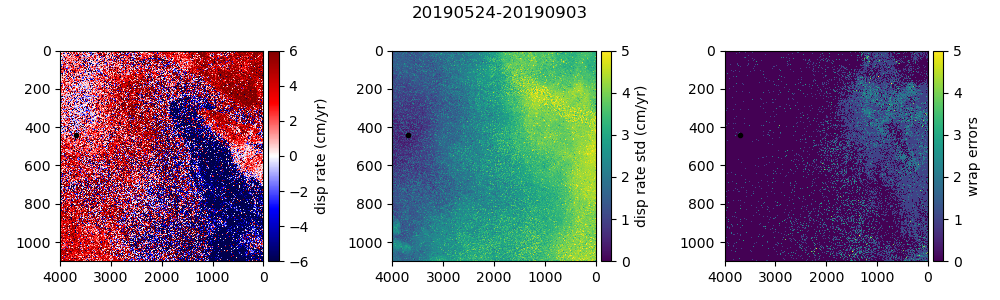

0.0


In [8]:
# plot what I just loaded in.
plt.figure(figsize=(10,3),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(disp_rates-np.mean(disp_rates), aspect='auto', cmap='seismic',vmin=-6.0,vmax=6.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])

plt.subplot(1,3,2)
plt.imshow(rate_std, aspect='auto', cmap='viridis',vmin=0,vmax=5.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
# plt.plot(3519,938,'m.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate std (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])

plt.subplot(1,3,3)
plt.imshow(num_errs, aspect='auto', cmap='viridis',vmin=0,vmax=5,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='wrap errors')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.suptitle(dates[start_indices[j]]+'-'+dates[end_indices[j]])
plt.show()
print(disp_rates[refY,refX])